In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
DATA_PATH = 'data/'
data = pd.read_pickle(DATA_PATH + 'train_data.pkl')

## Data

In [2]:
# sample size
k = 1
data = data.sample(frac=k, random_state=137)

In [3]:
# scaling data
from data_pipeline import data_pipeline

pipeline = data_pipeline()
data = pipeline.fit_transform(data)
unused_features = ['index']
data = data.drop(unused_features, axis=1)
data = data.astype(np.float32)
data['is_downstream_reconstructible'] = data['is_downstream_reconstructible'].astype(np.int64)
data.info()

# split on train and test
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

x_train = train_set.drop(['is_downstream_reconstructible', "seed_mva_value"], axis=1)
y_train = train_set['is_downstream_reconstructible'].copy()

x_test = test_set.drop(['is_downstream_reconstructible', "seed_mva_value"], axis=1)
y_test = test_set['is_downstream_reconstructible'].copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754766 entries, 1042314 to 3481
Data columns (total 16 columns):
is_downstream_reconstructible    int64
seed_chi2PerDoF                  float32
seed_p                           float32
seed_pt                          float32
seed_nLHCbIDs                    float32
seed_nbIT                        float32
seed_nLayers                     float32
seed_x                           float32
seed_y                           float32
seed_tx                          float32
seed_ty                          float32
seed_mva_value                   float32
seed_angle                       float32
seed_pr                          float32
seed_z_magnet                    float32
seed_r                           float32
dtypes: float32(15), int64(1)
memory usage: 127.2 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4157a0b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc3f8964710>]], dtype=object)

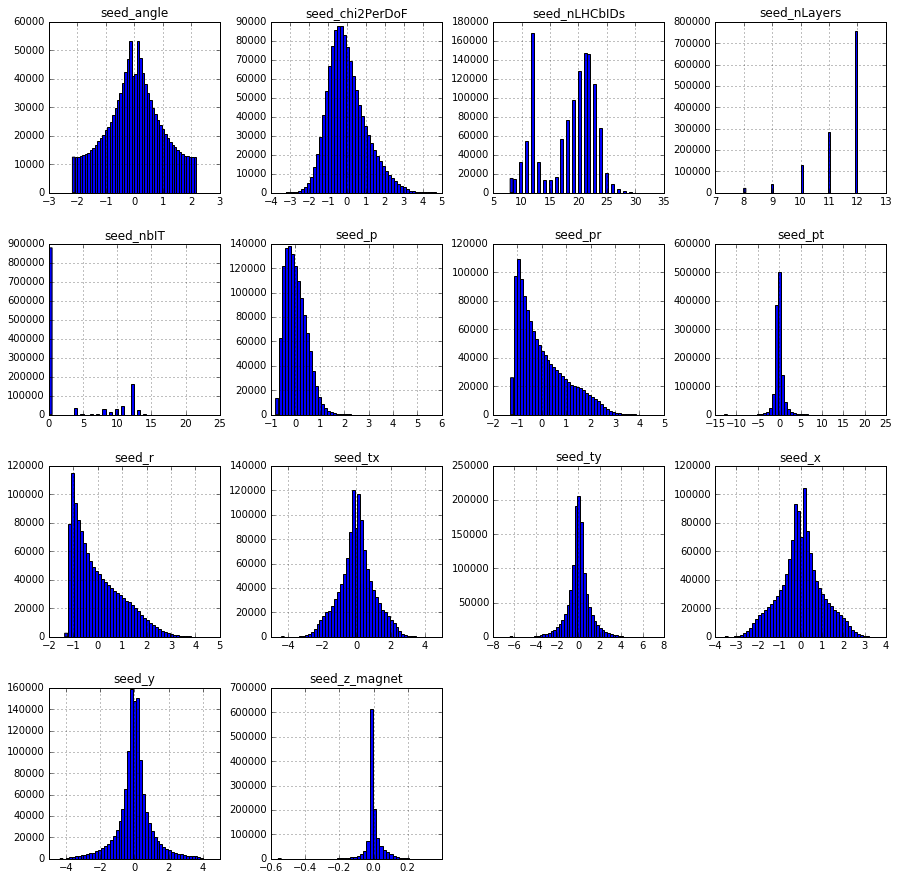

In [4]:
x_train.hist(bins=50, figsize=(15,15))

In [5]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228336 entries, 385628 to 103571
Data columns (total 14 columns):
seed_chi2PerDoF    1228336 non-null float32
seed_p             1228336 non-null float32
seed_pt            1228336 non-null float32
seed_nLHCbIDs      1228336 non-null float32
seed_nbIT          1228336 non-null float32
seed_nLayers       1228336 non-null float32
seed_x             1228336 non-null float32
seed_y             1228336 non-null float32
seed_tx            1228336 non-null float32
seed_ty            1228336 non-null float32
seed_angle         1228336 non-null float32
seed_pr            1228336 non-null float32
seed_z_magnet      1228336 non-null float32
seed_r             1228336 non-null float32
dtypes: float32(14)
memory usage: 75.0 MB


## Model

In [6]:
from DNN_softmax import DNNSoftmaxClf
import time
import tensorflow as tf

### training

In [7]:
DNNclf = DNNSoftmaxClf(act_fun=tf.nn.relu,
                       batch_size=100,
                       input_size=x_train.shape[1],
                       hidden_layers=3,
                       weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
                       layer_size=500,
                       n_epochs=10,
                       keep_prob=0.95,
                       learning_rate=1e-3,
                       optimizer=tf.train.AdamOptimizer,
                       logdir='saved_models/',
                      )
DNNclf.fit(x_train, y_train)

100%|██████████| 10/10 [57:15<00:00, 359.69s/it]


### model evaluation

In [8]:
# basic evaluation
from sklearn.metrics import accuracy_score, roc_auc_score
# print("train roc:{:.5}".format(roc_auc_score(y_train, DNNclf.predict_proba(x_train)[:,1])))
# default `score` is the accuracy of prediction
# print("train acc: {:.5}".format(DNNclf.score(x_train, y_train)))

print("test roc:{:.5}".format(roc_auc_score(y_test,DNNclf.predict_proba(x_test)[:,1])))
print("test acc: {:.5}".format(DNNclf.score(x_test, y_test)))

test roc:0.93804
test acc: 0.88614


### Integration with sklearn API

#### - cross validation

In [ ]:
# from sklearn.model_selection import cross_val_score
# DNNclf = DNNSoftmaxClf(input_size=x_train.shape[1])
# cross_val_score(DNNclf, x_train, y_train, cv=5, n_jobs=1) # tensorflow runs single training on all available cpu cores
#                                                         # so the cross validation shouldn't be run concurrently

#### - parameters grid search

In [45]:
from sklearn.model_selection import GridSearchCV
DNNClf = DNNSoftmaxClf(input_size=x_train.shape[1])

param_grid = {
    'act_fun': [tf.nn.relu],
    'n_epochs': [10],
    'keep_prob': [0.95],
    'hidden_layers': [3],
    'layer_size': [50, 100, 500],
    'learning_rate': [1e-2, 1e-3],
    'optimizer': [
        tf.train.AdamOptimizer,
    ],
    
}
gscv = GridSearchCV(DNNClf, param_grid, cv=5, verbose=1, n_jobs=1)
gscv.fit(x_train, y_train)

for key, value in gscv.cv_results_.items():
    print(key, value)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 10/10 [04:11<00:00, 25.09s/it]
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 62.4min finished
100%|██████████| 10/10 [05:16<00:00, 31.51s/it]


param_layer_size [50 50 100 100 500 500]
split3_test_score [ 0.86014413  0.85322259  0.85880054  0.86291275  0.85713122  0.86730996]
split0_test_score [ 0.8486218   0.8385652   0.85012825  0.85342616  0.82065062  0.85989984]
split1_train_score [ 0.85544008  0.85924697  0.85510418  0.86504891  0.86410228  0.86983297]
mean_test_score [ 0.85165793  0.85177193  0.85383212  0.85881567  0.8495163   0.8617146 ]
param_act_fun [<function relu at 0x7f3ef35b6ea0> <function relu at 0x7f3ef35b6ea0>
 <function relu at 0x7f3ef35b6ea0> <function relu at 0x7f3ef35b6ea0>
 <function relu at 0x7f3ef35b6ea0> <function relu at 0x7f3ef35b6ea0>]
split1_test_score [ 0.8510647   0.85517691  0.85126827  0.85908554  0.85900411  0.86433777]
param_learning_rate [0.01 0.001 0.01 0.001 0.01 0.001]
param_optimizer [<class 'tensorflow.python.training.adam.AdamOptimizer'>
 <class 'tensorflow.python.training.adam.AdamOptimizer'>
 <class 'tensorflow.python.training.adam.AdamOptimizer'>
 <class 'tensorflow.python.training.

In [46]:
gscv.best_params_

{'act_fun': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'hidden_layers': 3,
 'keep_prob': 0.95,
 'layer_size': 500,
 'learning_rate': 0.001,
 'n_epochs': 10,
 'optimizer': tensorflow.python.training.adam.AdamOptimizer}

### saving and restoring models

In [12]:
import time
DNNclf.save("test_{}".format(time.ctime()))
# the deafault model name is it's date and time of training
# DNNclf.restore_model('__path_to_model__/__our_model__')

TypeError: Cannot interpret feed_dict key as Tensor: The name 'save_1/Const:0' refers to a Tensor which does not exist. The operation, 'save_1/Const', does not exist in the graph.

In [ ]:
# to restore the model the DNNClf object has to be initialized 
# with the following parameters matching the original saved model
# DNNclf = DNNSoftmaxClf(
#     act_fun=tf.nn.relu,
#     input_size=x_train.shape[1],
#     hidden_layers=3,
#     layer_size=100,
# )
# # other parameters are not used for predictions

In [ ]:
# # attempting to save empty model
# DNNclf.save("test")

In [ ]:
# DNNclf.restore('best_models/Tue Jun 20 22:27:52 2017/')

In [ ]:
DNNclf.save("test")

### other

In [ ]:
DNNclf.predict_proba(x_test)

In [ ]:
DNNclf.predict(x_test)

In [ ]:
print("test roc:{:.5}".format(roc_auc_score(y_test,DNNclf.predict_proba(x_test)[:,1])))
print("test acc: {:.5}".format(DNNclf.score(x_test, y_test)))

In [ ]:
# manualy disconnect from TensorFlow
DNNclf.close_session()